In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
%matplotlib inline

In [2]:
df = pd.read_csv('QVI_data.csv')
df.head()

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264834 entries, 0 to 264833
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   LYLTY_CARD_NBR    264834 non-null  int64  
 1   DATE              264834 non-null  object 
 2   STORE_NBR         264834 non-null  int64  
 3   TXN_ID            264834 non-null  int64  
 4   PROD_NBR          264834 non-null  int64  
 5   PROD_NAME         264834 non-null  object 
 6   PROD_QTY          264834 non-null  int64  
 7   TOT_SALES         264834 non-null  float64
 8   PACK_SIZE         264834 non-null  int64  
 9   BRAND             264834 non-null  object 
 10  LIFESTAGE         264834 non-null  object 
 11  PREMIUM_CUSTOMER  264834 non-null  object 
dtypes: float64(1), int64(6), object(5)
memory usage: 24.2+ MB


In [4]:
df['DATE'] = pd.to_datetime(df['DATE'])
df['MONTH'] = df['DATE'].dt.to_period('M')

In [5]:
measures_over_time = df.groupby(['STORE_NBR', 'MONTH']).agg({'TOT_SALES':'sum', 'LYLTY_CARD_NBR': 'nunique', 'PROD_QTY':'mean'})
measures_over_time['AVG_TXN_PER_CUSTOMER'] = df.groupby(['STORE_NBR', 'MONTH'])['TXN_ID'].count()/measures_over_time['LYLTY_CARD_NBR']
measures_over_time['AVG_PRICE_PER_UNIT'] = df.groupby(['STORE_NBR', 'MONTH'])['TOT_SALES'].sum()/df.groupby(['STORE_NBR', 'MONTH'])['PROD_QTY'].sum()
measures_over_time.rename(columns={'LYLTY_CARD_NBR':"NO_OF_CUSTOMERS"}, inplace = True)
measures_over_time.head()

TOT_SALES  NO_OF_CUSTOMERS  PROD_QTY  AVG_TXN_PER_CUSTOMER  \
STORE_NBR MONTH                                                                 
1         2018-07      206.9               49  1.192308              1.061224   
          2018-08      176.1               42  1.255814              1.023810   
          2018-09      278.8               59  1.209677              1.050847   
          2018-10      188.1               44  1.288889              1.022727   
          2018-11      192.6               46  1.212766              1.021739   

                   AVG_PRICE_PER_UNIT  
STORE_NBR MONTH                        
1         2018-07            3.337097  
          2018-08            3.261111  
          2018-09            3.717333  
          2018-10            3.243103  
          2018-11            3.378947

In [6]:
measures_over_time.reset_index(inplace=True)
measures_over_time.head()

,STORE_NBR,MONTH,TOT_SALES,NO_OF_CUSTOMERS,PROD_QTY,AVG_TXN_PER_CUSTOMER,AVG_PRICE_PER_UNIT
0,1,2018-07,206.9,49,1.192308,1.061224,3.337097
1,1,2018-08,176.1,42,1.255814,1.023810,3.261111
2,1,2018-09,278.8,59,1.209677,1.050847,3.717333
3,1,2018-10,188.1,44,1.288889,1.022727,3.243103
4,1,2018-11,192.6,46,1.212766,1.021739,3.378947


In [7]:
store_counts = measures_over_time.groupby('STORE_NBR').size().reset_index(name='N')
stores_with_full_observation = store_counts[store_counts['N']==12]
stores_with_full_observation

,STORE_NBR,N
0,1,12
1,2,12
2,3,12
3,4,12
4,5,12
...,...,...
267,268,12
268,269,12
269,270,12
270,271,12


In [8]:
pre_trial_measures = measures_over_time[(measures_over_time['STORE_NBR'].isin(stores_with_full_observation['STORE_NBR'])) &
                                       (measures_over_time['MONTH']<'2019-02')]

# correlation calculation

In [9]:
def correlation_calculation(dataframe, metric, trial_store):
    corr_table = pd.DataFrame(columns=['trial_store', 'control_store', 'correlation'])
    store_numbers = dataframe['STORE_NBR'].unique()
    for store in store_numbers:
        if store != trial_store:
            trial_data = dataframe[dataframe['STORE_NBR'] == trial_store][[metric]].reset_index()
            control_data = dataframe[dataframe['STORE_NBR'] == store][[metric]].reset_index()
            
            correlation = trial_data.corrwith(control_data)[1]
            calculated_measure = pd.DataFrame({'trial_store':[trial_store],
                                               'control_store':[store],
                                               'correlation':[correlation]})
            
            corr_table = pd.concat([corr_table, calculated_measure], ignore_index=True)
            
    return corr_table

# standardised magnitude distance

In [10]:
def magnitude_calculation(dataframe, metric, trial_store):
    calculated_distance_df = pd.DataFrame(columns=['month', 'trial_store', 'control_store', 'measure'])
    store_numbers = dataframe['STORE_NBR'].unique()
    
    for store in store_numbers:
        if store != trial_store:
            trial_data = dataframe[dataframe['STORE_NBR']==trial_store].reset_index()
            control_data = dataframe[dataframe['STORE_NBR']==store].reset_index()
        
            measure = abs(trial_data[metric].values-control_data[metric].values)
        
            calculated_measure = pd.DataFrame({'month':trial_data['MONTH'].values,
                                          'trial_store':trial_store,
                                          'control_store':store,
                                          'measure':measure})
        
            calculated_distance_df = pd.concat([calculated_distance_df, calculated_measure], ignore_index=True)
     
    min_max_dist = calculated_distance_df.groupby(['month', 'trial_store'])['measure'].agg(['min', 'max']).reset_index()
    calculated_distance_df = calculated_distance_df.merge(min_max_dist, on=['month', 'trial_store'])
    calculated_distance_df['magnitude_measure'] = 1 - (calculated_distance_df['measure'] - calculated_distance_df['min']) / (calculated_distance_df['max'] - calculated_distance_df['min'])
    
    final_dist_df = calculated_distance_df.groupby(['trial_store', 'control_store'])['magnitude_measure'].mean().reset_index()
    
    return final_dist_df

# Analysis of trial store 77 to find its matching control store

In [11]:
store_77_sales_corr = correlation_calculation(pre_trial_measures, 'TOT_SALES', 77)
store_77_customers_corr = correlation_calculation(pre_trial_measures, 'NO_OF_CUSTOMERS', 77)
store_77_sales_corr

,trial_store,control_store,correlation
0,77,1,0.075218
1,77,2,-0.263079
2,77,3,0.806644
3,77,4,-0.263300
4,77,5,-0.110652
...,...,...,...
254,77,268,0.344757
255,77,269,-0.315730
256,77,270,0.315430
257,77,271,0.355487


In [12]:
store_77_sales_magnitude = magnitude_calculation(pre_trial_measures, 'TOT_SALES', 77)
store_77_customers_magnitude = magnitude_calculation(pre_trial_measures, 'NO_OF_CUSTOMERS', 77)
store_77_sales_magnitude

,trial_store,control_store,magnitude_measure
0,77,1,0.955061
1,77,2,0.939318
2,77,3,0.354963
3,77,4,0.177414
4,77,5,0.554066
...,...,...,...
254,77,268,0.962563
255,77,269,0.452903
256,77,270,0.446991
257,77,271,0.553304


# Score Control Function

In [13]:
def score_control(df_sales_corr, df_sales_magnitude, df_cust_corr, df_cust_magnitude, metric):
    sales_score_df = df_sales_corr.merge(df_sales_magnitude, on=metric)
    sales_score_df = sales_score_df.drop('trial_store_y', axis=1)
    sales_score_df['sales_score'] = sales_score_df['correlation']*0.5 + sales_score_df['magnitude_measure']*0.5
    
    customers_score_df = df_cust_corr.merge(df_cust_magnitude, on=metric)
    customers_score_df = customers_score_df.drop('trial_store_y', axis=1)
    customers_score_df['customers_score'] = customers_score_df['correlation']*0.5 + customers_score_df['magnitude_measure']*0.5
    
    score_control = sales_score_df.merge(customers_score_df, on=metric, suffixes=['_sales', '_customers'])
    score_control = score_control.drop('trial_store_x_customers', axis=1)
    score_control['final_control_score'] = (score_control['sales_score'] + score_control['customers_score'])/2
    
    return score_control

In [14]:
score_control_77 = score_control(store_77_sales_corr,
                                store_77_sales_magnitude,
                                store_77_customers_corr,
                                store_77_customers_magnitude,
                                'control_store')

score_control_77.head()

,trial_store_x_sales,control_store,correlation_sales,magnitude_measure_sales,sales_score,correlation_customers,magnitude_measure_customers,customers_score,final_control_score
0,77,1,0.075218,0.955061,0.515139,0.322168,0.940321,0.631244,0.573192
1,77,2,-0.263079,0.939318,0.338120,-0.572051,0.924638,0.176294,0.257207
2,77,3,0.806644,0.354963,0.580803,0.834207,0.345067,0.589637,0.585220
3,77,4,-0.263300,0.177414,-0.042943,-0.295639,0.189579,-0.053030,-0.047986
4,77,5,-0.110652,0.554066,0.221707,0.370659,0.481199,0.425929,0.323818


In [15]:
control_store_77 = score_control_77[score_control_77['final_control_score']==score_control_77['final_control_score'].max()]['control_store']
control_store_77

220    233
Name: control_store, dtype: object

# Function to extract Trial and Control store's performance

In [20]:

def performance(trial_store, control_store, metric):
    
    measures_over_time_metrics = measures_over_time.copy()
    
    for i, j in measures_over_time_metrics.iterrows():
        if j['STORE_NBR'] == trial_store:
            measures_over_time_metrics.loc[i, 'STORE_TYPE'] = 'Trial'
        elif j['STORE_NBR'] == control_store:
            measures_over_time_metrics.loc[i, 'STORE_TYPE'] = 'Control'
        else:
            measures_over_time_metrics.loc[i, 'STORE_TYPE'] = 'Other stores'
            
    measures_over_time_metrics['TRANSACTION_MONTH'] = measures_over_time_metrics['MONTH'].astype(str)
    measures_over_time_metrics['TRANSACTION_MONTH'] = pd.to_datetime(measures_over_time_metrics['TRANSACTION_MONTH'], format='%Y-%m-%d')
    
    past_metric = measures_over_time_metrics[measures_over_time_metrics['MONTH']<'2019-03'].groupby(['TRANSACTION_MONTH', 'STORE_TYPE'])[metric].mean()
    past_metric = pd.DataFrame(past_metric).reset_index()
    past_metric['MONTH_NAME'] = past_metric['TRANSACTION_MONTH'].dt.strftime('%B')
    
    return past_metric


# Plot functions

In [42]:
# Sales Plot

def sales_comparison_plots(data, x, y, hue, kind):
    
    ax = sns.relplot(data=data, x=x,y=y,hue=hue,kind=kind, height=8, aspect=2)
    plt.xlabel('Month of operation')
    plt.ylabel('Total sales')
    plt.title('Total sales by month')
    plt.xticks(data['TRANSACTION_MONTH'], data['MONTH_NAME'], rotation=45)
    
    return ax

# Sales analysis of store 77 and store 233

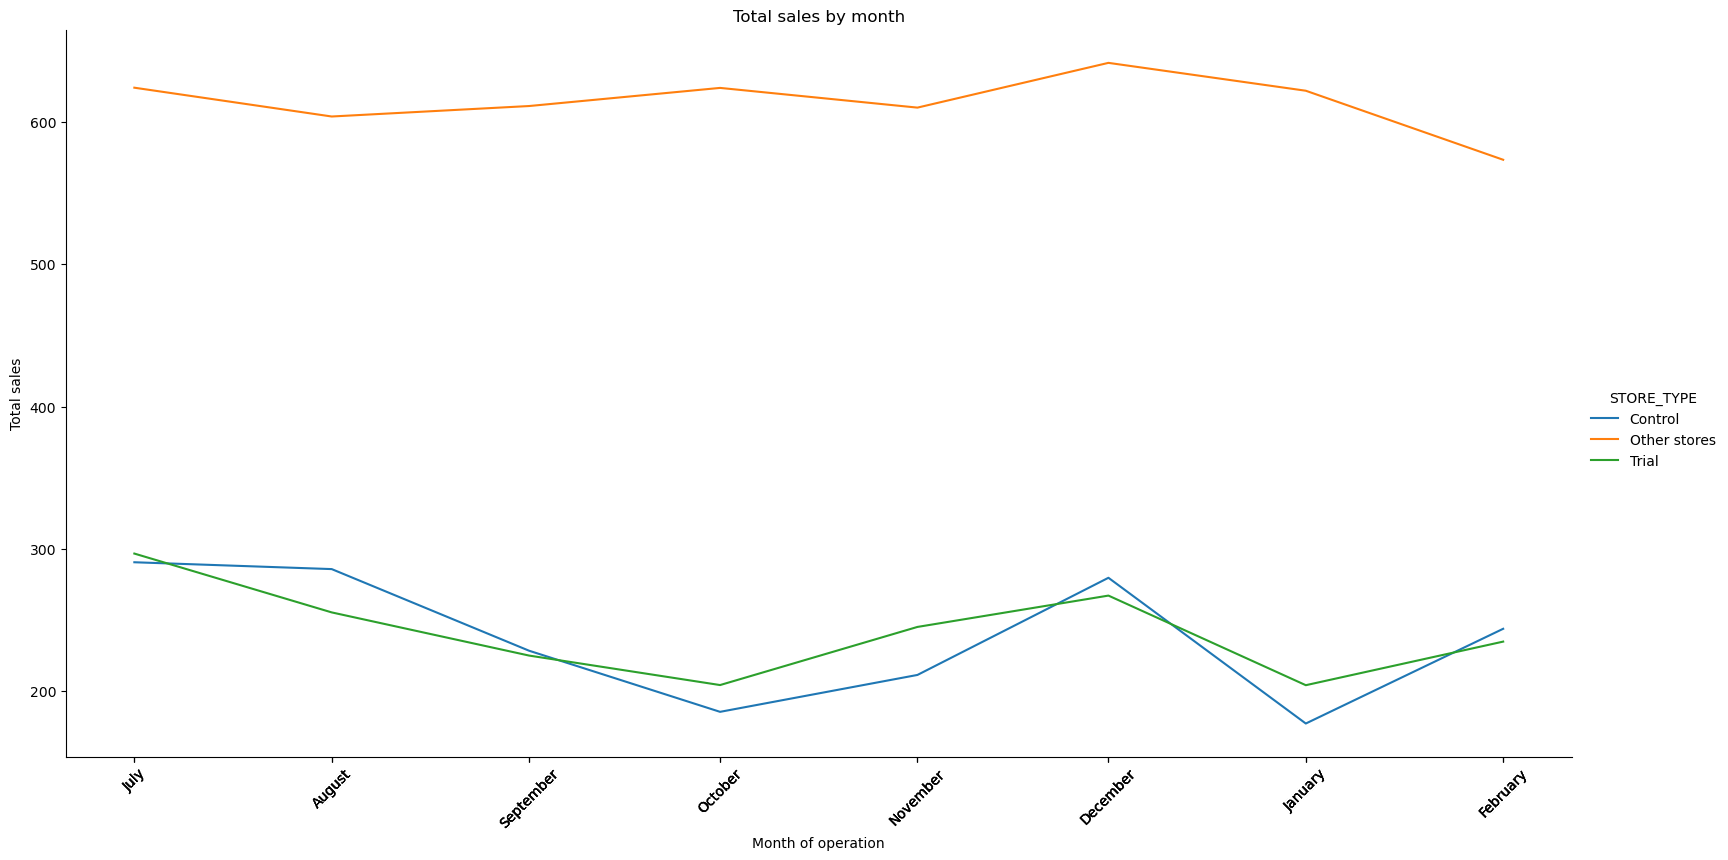

In [43]:
past_sales_77_233 = performance(77, 233, "TOT_SALES")
plot_sales_77_233 = sales_comparison_plots(past_sales_77_233,
                                           'TRANSACTION_MONTH',
                                           'TOT_SALES',
                                           'STORE_TYPE',
                                           'line')

In [45]:
# Customers Plot

def customers_comparison_plots(data, x, y, hue, kind):
    ax = sns.relplot(data=data, x=x,y=y,hue=hue,kind=kind, height=7, aspect=2)
    plt.xlabel('Month of operation')
    plt.ylabel('Total customers')
    plt.title('Total customers by month')
    plt.xticks(data['TRANSACTION_MONTH'], data['MONTH_NAME'], rotation=45)
    
    return ax

# Scaling Factor function

In [46]:
def scaling_factor(dataframe, metric, trial_store, control_store):
    scaling_factor = dataframe[(dataframe['STORE_NBR']==trial_store)&(dataframe['MONTH']<'2019-02')][metric].sum()/\
                        dataframe[(dataframe['STORE_NBR']==control_store)&(dataframe['MONTH']<'2019-02')][metric].sum()
    
    return scaling_factor

In [47]:
sales_scaling_factor_233 = scaling_factor(pre_trial_measures, 'TOT_SALES', 77, 233)
sales_scaling_factor_233

1.023617303289553

# Trial Assessment Dataframe Function

In [50]:

def metric_percentage_difference(trial_store, control_store, metric, scaling_factor_metric, control_metric):
    measures_over_time_metric = measures_over_time.copy()
    
    measures_over_time_metric.loc[measures_over_time_metric['STORE_NBR']==control_store, control_metric] = measures_over_time_metric.loc[measures_over_time_metric['STORE_NBR']==control_store, metric]*scaling_factor_metric
    scaled_control_metric = measures_over_time_metric[measures_over_time_metric['STORE_NBR']==control_store]
    
    percentage_difference = pd.merge(scaled_control_metric, measures_over_time_metric[measures_over_time_metric['STORE_NBR']==trial_store][[metric, 'MONTH']], on='MONTH', suffixes=['_control', '_trial'])
    
    return percentage_difference

In [51]:
sales_percentage_difference_77_233 = metric_percentage_difference(77, 233, 'TOT_SALES', sales_scaling_factor_233, 'CONTROL_SALES')
sales_percentage_difference_77_233.head()

,STORE_NBR,MONTH,TOT_SALES_control,NO_OF_CUSTOMERS,PROD_QTY,AVG_TXN_PER_CUSTOMER,AVG_PRICE_PER_UNIT,CONTROL_SALES,TOT_SALES_trial
0,233,2018-07,290.7,51,1.629630,1.058824,3.303409,297.565550,296.8
1,233,2018-08,285.9,48,1.600000,1.041667,3.573750,292.652187,255.5
2,233,2018-09,228.6,42,1.555556,1.071429,3.265714,233.998916,225.2
3,233,2018-10,185.7,35,1.555556,1.028571,3.316071,190.085733,204.5
4,233,2018-11,211.6,40,1.512195,1.025000,3.412903,216.597421,245.3


In [52]:
sales_percentage_difference_77_233['PERCENTAGE_DIFF'] = abs(sales_percentage_difference_77_233['CONTROL_SALES']-
                                                           sales_percentage_difference_77_233['TOT_SALES_trial'])/\
                                                            sales_percentage_difference_77_233['CONTROL_SALES']

sales_percentage_difference_77_233['TRANSACTION_MONTH'] = sales_percentage_difference_77_233['MONTH'].astype(str)
sales_percentage_difference_77_233['TRANSACTION_MONTH'] = pd.to_datetime(sales_percentage_difference_77_233['TRANSACTION_MONTH'], format='%Y-%m-%d')


sales_std_dev_77_233 = sales_percentage_difference_77_233[sales_percentage_difference_77_233['MONTH']<'2019-02']['PERCENTAGE_DIFF'].std()
sales_std_dev_77_233

0.04994076264142537

In [53]:
sales_percentage_difference_77_233['t_value'] = (sales_percentage_difference_77_233['PERCENTAGE_DIFF'] - 0) / sales_std_dev_77_233
sales_percentage_difference_77_233

,STORE_NBR,MONTH,TOT_SALES_control,NO_OF_CUSTOMERS,PROD_QTY,AVG_TXN_PER_CUSTOMER,AVG_PRICE_PER_UNIT,CONTROL_SALES,TOT_SALES_trial,PERCENTAGE_DIFF,TRANSACTION_MONTH,t_value
0,233,2018-07,290.7,51,1.629630,1.058824,3.303409,297.565550,296.8,0.002573,2018-07-01,0.051515
1,233,2018-08,285.9,48,1.600000,1.041667,3.573750,292.652187,255.5,0.126950,2018-08-01,2.542011
2,233,2018-09,228.6,42,1.555556,1.071429,3.265714,233.998916,225.2,0.037602,2018-09-01,0.752940
3,233,2018-10,185.7,35,1.555556,1.028571,3.316071,190.085733,204.5,0.075830,2018-10-01,1.518406
4,233,2018-11,211.6,40,1.512195,1.025000,3.412903,216.597421,245.3,0.132516,2018-11-01,2.653459
5,233,2018-12,279.8,47,1.500000,1.063830,3.730667,286.408121,267.3,0.066716,2018-12-01,1.335911
6,233,2019-01,177.5,35,1.342857,1.000000,3.776596,181.692071,204.4,0.124980,2019-01-01,2.502571
7,233,2019-02,244.0,45,1.489362,1.044444,3.485714,249.762622,235.0,0.059107,2019-02-01,1.183534
8,233,2019-03,199.1,40,1.439024,1.025000,3.374576,203.802205,278.5,0.366521,2019-03-01,7.339116
9,233,2019-04,158.6,30,1.393939,1.100000,3.447826,162.345704,263.5,0.623080,2019-04-01,12.476373


In [54]:
trial_period = ['2019-02-01', '2019-03-01', '2019-04-01']
sales_percentage_difference_77_233[sales_percentage_difference_77_233['TRANSACTION_MONTH'].isin(trial_period)][['TRANSACTION_MONTH','t_value']]

,TRANSACTION_MONTH,t_value
7,2019-02-01,1.183534
8,2019-03-01,7.339116
9,2019-04-01,12.476373


In [55]:
from scipy import stats

In [56]:
stats.t.ppf(0.95, 7)

1.894578605061305

In [57]:
def trial_and_control_assessemnt(trial_store, control_store, metric, std_dev):
    measures_over_time_metric = measures_over_time.copy()
    
    for i, j in measures_over_time_metric.iterrows():
        if j['STORE_NBR']==trial_store:
            measures_over_time_metric.loc[i, 'STORE_TYPE']='Trial'
        elif j['STORE_NBR']==control_store:
            measures_over_time_metric.loc[i, 'STORE_TYPE']='Control'
        else:
            measures_over_time_metric.loc[i, 'STORE_TYPE']='Other stores'
            
    trial_and_control_metric = measures_over_time_metric[measures_over_time_metric['STORE_TYPE'].isin(['Trial', 'Control'])]
    
    past_metric_control95 = trial_and_control_metric[trial_and_control_metric['STORE_TYPE']=='Control'].reset_index(drop=True)
    past_metric_control95['STORE_TYPE'] = 'Control 95% CI'
    past_metric_control95[metric] = past_metric_control95.loc[:, metric]*(1 + (std_dev*2))
    
    past_metric_control5 = trial_and_control_metric[trial_and_control_metric['STORE_TYPE']=='Control'].reset_index(drop=True)
    past_metric_control5['STORE_TYPE'] = 'Control 5% CI'
    past_metric_control5[metric] = past_metric_control5.loc[:, metric]*(1 - (std_dev*2))
    
    trial_assessment = pd.concat([trial_and_control_metric, past_metric_control95, past_metric_control5])
    trial_assessment['TRANSACTION_MONTH'] = trial_assessment['MONTH'].astype(str)
    trial_assessment['TRANSACTION_MONTH'] = pd.to_datetime(trial_assessment['TRANSACTION_MONTH'], format='%Y-%m-%d')
    trial_assessment['MONTH_NAME'] = trial_assessment['TRANSACTION_MONTH'].dt.strftime('%B')
    trial_assessment = trial_assessment.reset_index(drop=True)
    
    return trial_assessment

In [58]:
trial_77_control_233_sales_assessment = trial_and_control_assessemnt(77, 233, "TOT_SALES", sales_std_dev_77_233)
trial_77_control_233_sales_assessment

,STORE_NBR,MONTH,TOT_SALES,NO_OF_CUSTOMERS,PROD_QTY,AVG_TXN_PER_CUSTOMER,AVG_PRICE_PER_UNIT,STORE_TYPE,TRANSACTION_MONTH,MONTH_NAME
0,77,2018-07,296.800000,51,1.527273,1.078431,3.533333,Trial,2018-07-01,July
1,77,2018-08,255.500000,47,1.541667,1.021277,3.452703,Trial,2018-08-01,August
2,77,2018-09,225.200000,42,1.590909,1.047619,3.217143,Trial,2018-09-01,September
3,77,2018-10,204.500000,37,1.368421,1.027027,3.932692,Trial,2018-10-01,October
4,77,2018-11,245.300000,41,1.522727,1.073171,3.661194,Trial,2018-11-01,November
5,77,2018-12,267.300000,46,1.469388,1.065217,3.712500,Trial,2018-12-01,December
6,77,2019-01,204.400000,35,1.666667,1.114286,3.144615,Trial,2019-01-01,January
7,77,2019-02,235.000000,45,1.644444,1.000000,3.175676,Trial,2019-02-01,February
8,77,2019-03,278.500000,50,1.490909,1.100000,3.396341,Trial,2019-03-01,March
9,77,2019-04,263.500000,47,1.625000,1.021277,3.378205,Trial,2019-04-01,April


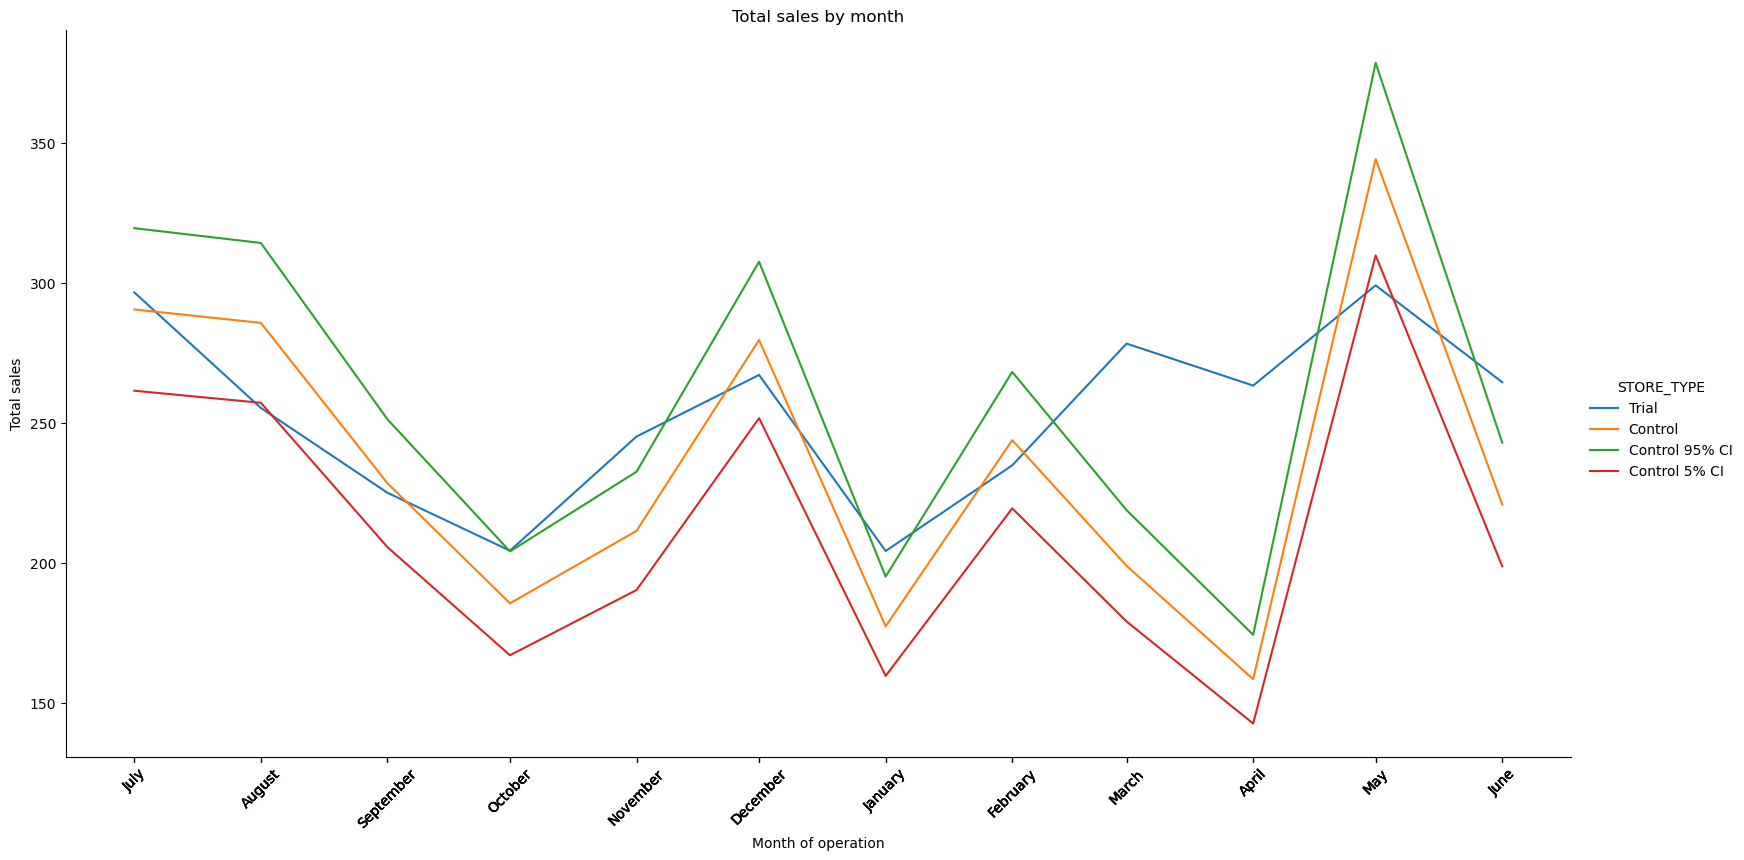

In [59]:
sales_comparison_plots(trial_77_control_233_sales_assessment,
                       'TRANSACTION_MONTH',
                       'TOT_SALES', 
                       'STORE_TYPE',
                       'line')

# Customers analysis of store 77 and store 233 


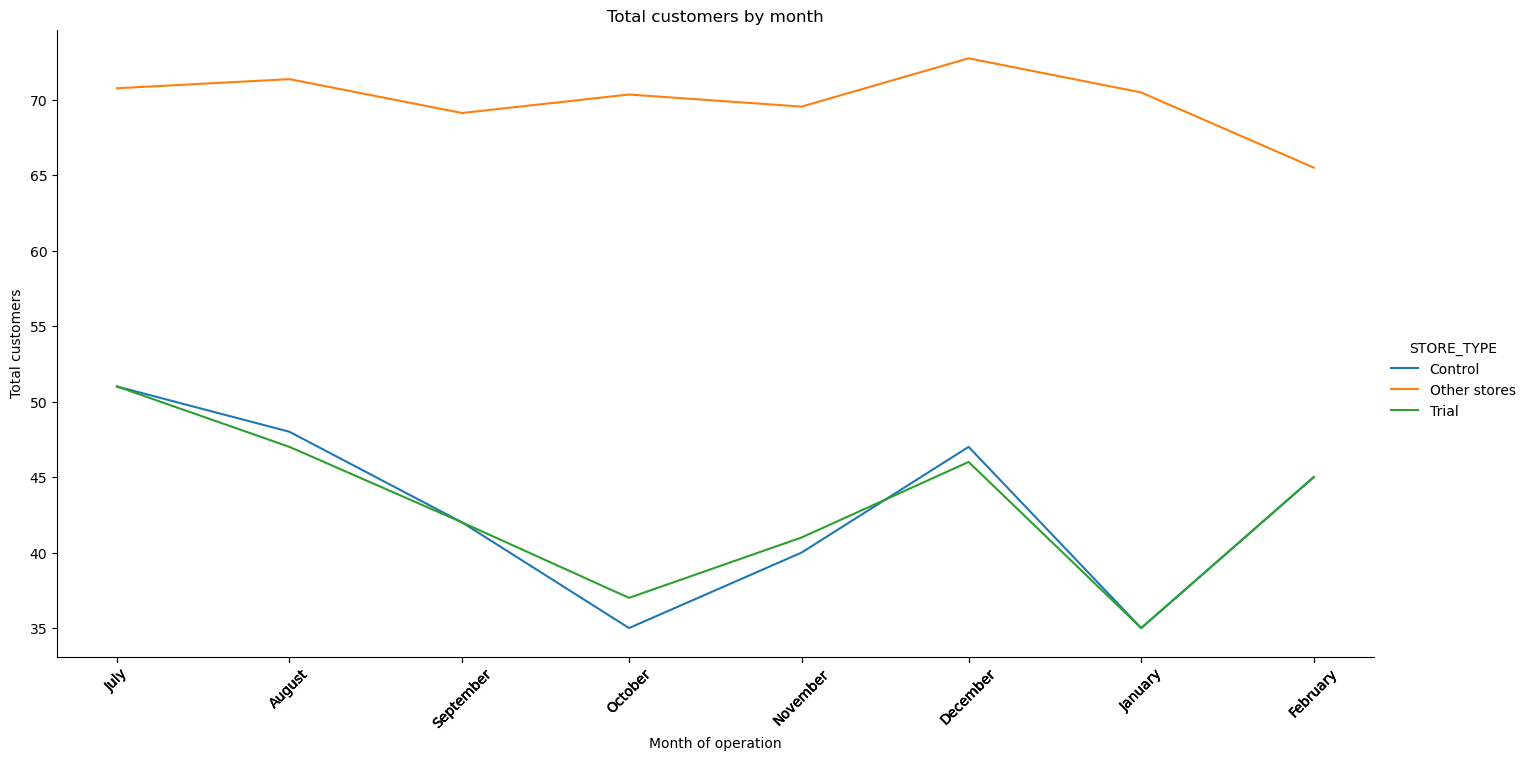

In [60]:
past_customers_77_233 = performance(77, 233, "NO_OF_CUSTOMERS")
past_customers_77_233 = customers_comparison_plots(past_customers_77_233,
                                                   'TRANSACTION_MONTH',
                                                   'NO_OF_CUSTOMERS',
                                                   'STORE_TYPE',
                                                   'line')

In [61]:
customers_scaling_factor_233 = scaling_factor(pre_trial_measures, 'NO_OF_CUSTOMERS', 77, 233)
customers_scaling_factor_233

1.0033557046979866

In [62]:
customers_percentage_difference_77_233 = metric_percentage_difference(77, 233, 'NO_OF_CUSTOMERS', customers_scaling_factor_233, 'CONTROL_CUSTOMERS')
customers_percentage_difference_77_233.head()

,STORE_NBR,MONTH,TOT_SALES,NO_OF_CUSTOMERS_control,PROD_QTY,AVG_TXN_PER_CUSTOMER,AVG_PRICE_PER_UNIT,CONTROL_CUSTOMERS,NO_OF_CUSTOMERS_trial
0,233,2018-07,290.7,51,1.629630,1.058824,3.303409,51.171141,51
1,233,2018-08,285.9,48,1.600000,1.041667,3.573750,48.161074,47
2,233,2018-09,228.6,42,1.555556,1.071429,3.265714,42.140940,42
3,233,2018-10,185.7,35,1.555556,1.028571,3.316071,35.117450,37
4,233,2018-11,211.6,40,1.512195,1.025000,3.412903,40.134228,41


In [63]:
customers_percentage_difference_77_233['PERCENTAGE_DIFF'] = abs(customers_percentage_difference_77_233['CONTROL_CUSTOMERS']-
                                                           customers_percentage_difference_77_233['NO_OF_CUSTOMERS_trial'])/\
                                                            customers_percentage_difference_77_233['CONTROL_CUSTOMERS']

customers_percentage_difference_77_233['TRANSACTION_MONTH'] = customers_percentage_difference_77_233['MONTH'].astype(str)
customers_percentage_difference_77_233['TRANSACTION_MONTH'] = pd.to_datetime(customers_percentage_difference_77_233['TRANSACTION_MONTH'], format='%Y-%m-%d')

customers_std_dev_77_233 = customers_percentage_difference_77_233[customers_percentage_difference_77_233['MONTH']<'2019-02']['PERCENTAGE_DIFF'].std()
customers_std_dev_77_233

0.01824074855824395

In [64]:
customers_percentage_difference_77_233['t_value'] = (customers_percentage_difference_77_233['PERCENTAGE_DIFF'] - 0) / customers_std_dev_77_233
customers_percentage_difference_77_233

,STORE_NBR,MONTH,TOT_SALES,NO_OF_CUSTOMERS_control,PROD_QTY,AVG_TXN_PER_CUSTOMER,AVG_PRICE_PER_UNIT,CONTROL_CUSTOMERS,NO_OF_CUSTOMERS_trial,PERCENTAGE_DIFF,TRANSACTION_MONTH,t_value
0,233,2018-07,290.7,51,1.629630,1.058824,3.303409,51.171141,51,0.003344,2018-07-01,0.183352
1,233,2018-08,285.9,48,1.600000,1.041667,3.573750,48.161074,47,0.024108,2018-08-01,1.321664
2,233,2018-09,228.6,42,1.555556,1.071429,3.265714,42.140940,42,0.003344,2018-09-01,0.183352
3,233,2018-10,185.7,35,1.555556,1.028571,3.316071,35.117450,37,0.053607,2018-10-01,2.938874
4,233,2018-11,211.6,40,1.512195,1.025000,3.412903,40.134228,41,0.021572,2018-11-01,1.182622
5,233,2018-12,279.8,47,1.500000,1.063830,3.730667,47.157718,46,0.024550,2018-12-01,1.345883
6,233,2019-01,177.5,35,1.342857,1.000000,3.776596,35.117450,35,0.003344,2019-01-01,0.183352
7,233,2019-02,244.0,45,1.489362,1.044444,3.485714,45.151007,45,0.003344,2019-02-01,0.183352
8,233,2019-03,199.1,40,1.439024,1.025000,3.374576,40.134228,50,0.245819,2019-03-01,13.476388
9,233,2019-04,158.6,30,1.393939,1.100000,3.447826,30.100671,47,0.561427,2019-04-01,30.778725


In [65]:
trial_period = ['2019-02-01', '2019-03-01', '2019-04-01']
customers_percentage_difference_77_233[customers_percentage_difference_77_233['TRANSACTION_MONTH'].isin(trial_period)][['TRANSACTION_MONTH','t_value']]

,TRANSACTION_MONTH,t_value
7,2019-02-01,0.183352
8,2019-03-01,13.476388
9,2019-04-01,30.778725


In [66]:
trial_77_control_233_customers_assessment = trial_and_control_assessemnt(77, 233, "NO_OF_CUSTOMERS", customers_std_dev_77_233)
trial_77_control_233_customers_assessment.head()

,STORE_NBR,MONTH,TOT_SALES,NO_OF_CUSTOMERS,PROD_QTY,AVG_TXN_PER_CUSTOMER,AVG_PRICE_PER_UNIT,STORE_TYPE,TRANSACTION_MONTH,MONTH_NAME
0,77,2018-07,296.8,51.0,1.527273,1.078431,3.533333,Trial,2018-07-01,July
1,77,2018-08,255.5,47.0,1.541667,1.021277,3.452703,Trial,2018-08-01,August
2,77,2018-09,225.2,42.0,1.590909,1.047619,3.217143,Trial,2018-09-01,September
3,77,2018-10,204.5,37.0,1.368421,1.027027,3.932692,Trial,2018-10-01,October
4,77,2018-11,245.3,41.0,1.522727,1.073171,3.661194,Trial,2018-11-01,November


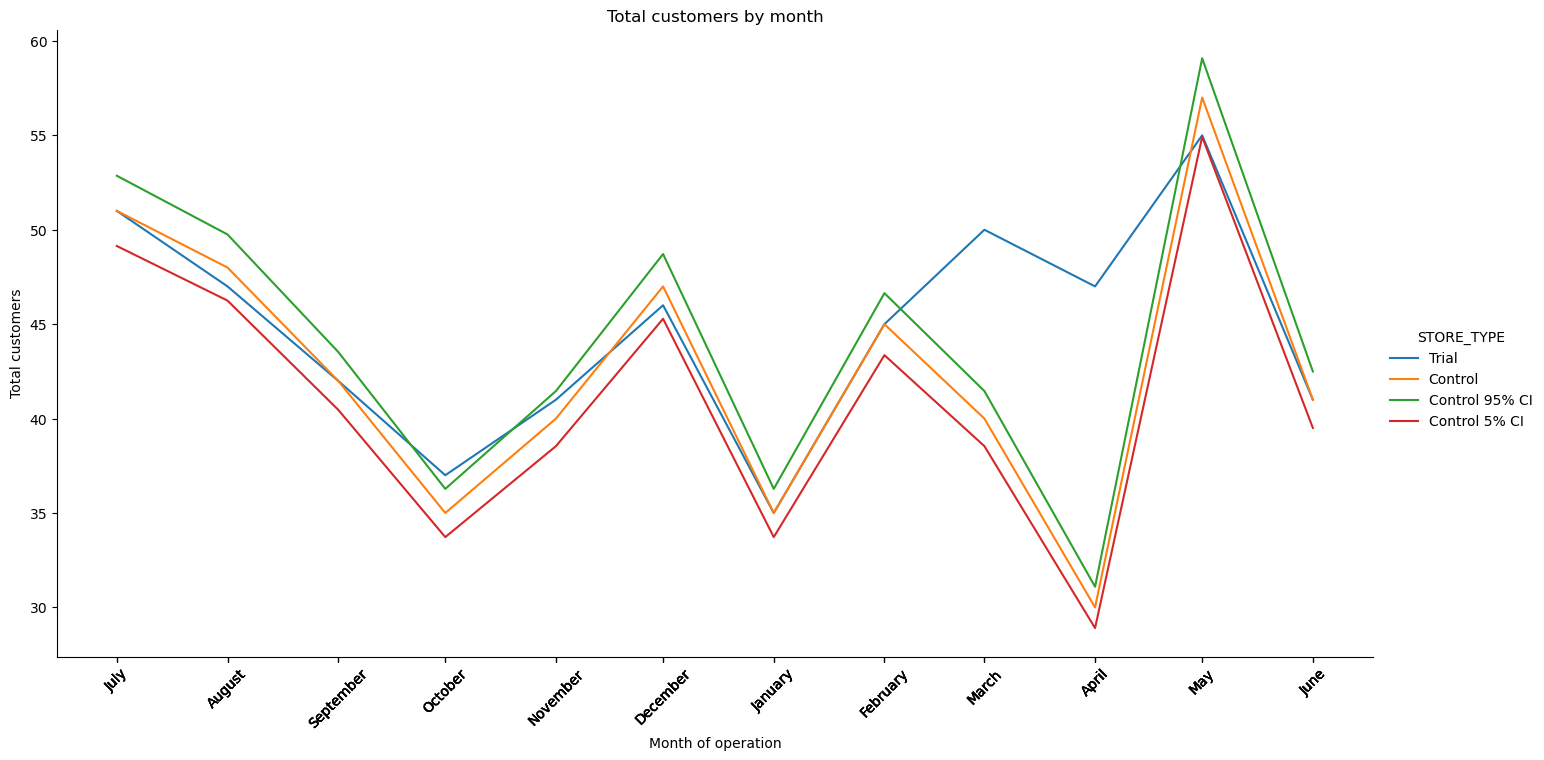

In [67]:
customers_comparison_plots(trial_77_control_233_customers_assessment,
                           'TRANSACTION_MONTH',
                           'NO_OF_CUSTOMERS',
                           'STORE_TYPE',
                           'line')

# Analysis of store 86 to find its control store

In [68]:
store_86_sales_corr = correlation_calculation(pre_trial_measures, 'TOT_SALES', 86)
store_86_customers_corr = correlation_calculation(pre_trial_measures, 'NO_OF_CUSTOMERS', 86)

In [69]:
store_86_sales_magnitude = magnitude_calculation(pre_trial_measures, 'TOT_SALES', 86)
store_86_customers_magnitude = magnitude_calculation(pre_trial_measures, 'NO_OF_CUSTOMERS', 86)

In [70]:
score_control_86 = score_control(store_86_sales_corr,
                                store_86_sales_magnitude,
                                store_86_customers_corr,
                                store_86_customers_magnitude,
                                'control_store')

score_control_86.head()

,trial_store_x_sales,control_store,correlation_sales,magnitude_measure_sales,sales_score,correlation_customers,magnitude_measure_customers,customers_score,final_control_score
0,86,1,0.445632,0.220565,0.333099,0.485831,0.444597,0.465214,0.399156
1,86,2,-0.403835,0.179640,-0.112097,-0.086161,0.380620,0.147230,0.017566
2,86,3,-0.261284,0.762894,0.250805,-0.353786,0.911850,0.279032,0.264919
3,86,4,-0.039035,0.498526,0.229745,-0.169608,0.773922,0.302157,0.265951
4,86,5,0.235159,0.929321,0.582240,-0.253229,0.926509,0.336640,0.459440


In [71]:
control_store_86 = score_control_86[score_control_86['final_control_score']==score_control_86['final_control_score'].max()]['control_store']
control_store_86

146    155
Name: control_store, dtype: object

# The control store for trial store 86 is store 155

# Sales analysis of trial store 86 and control store 155

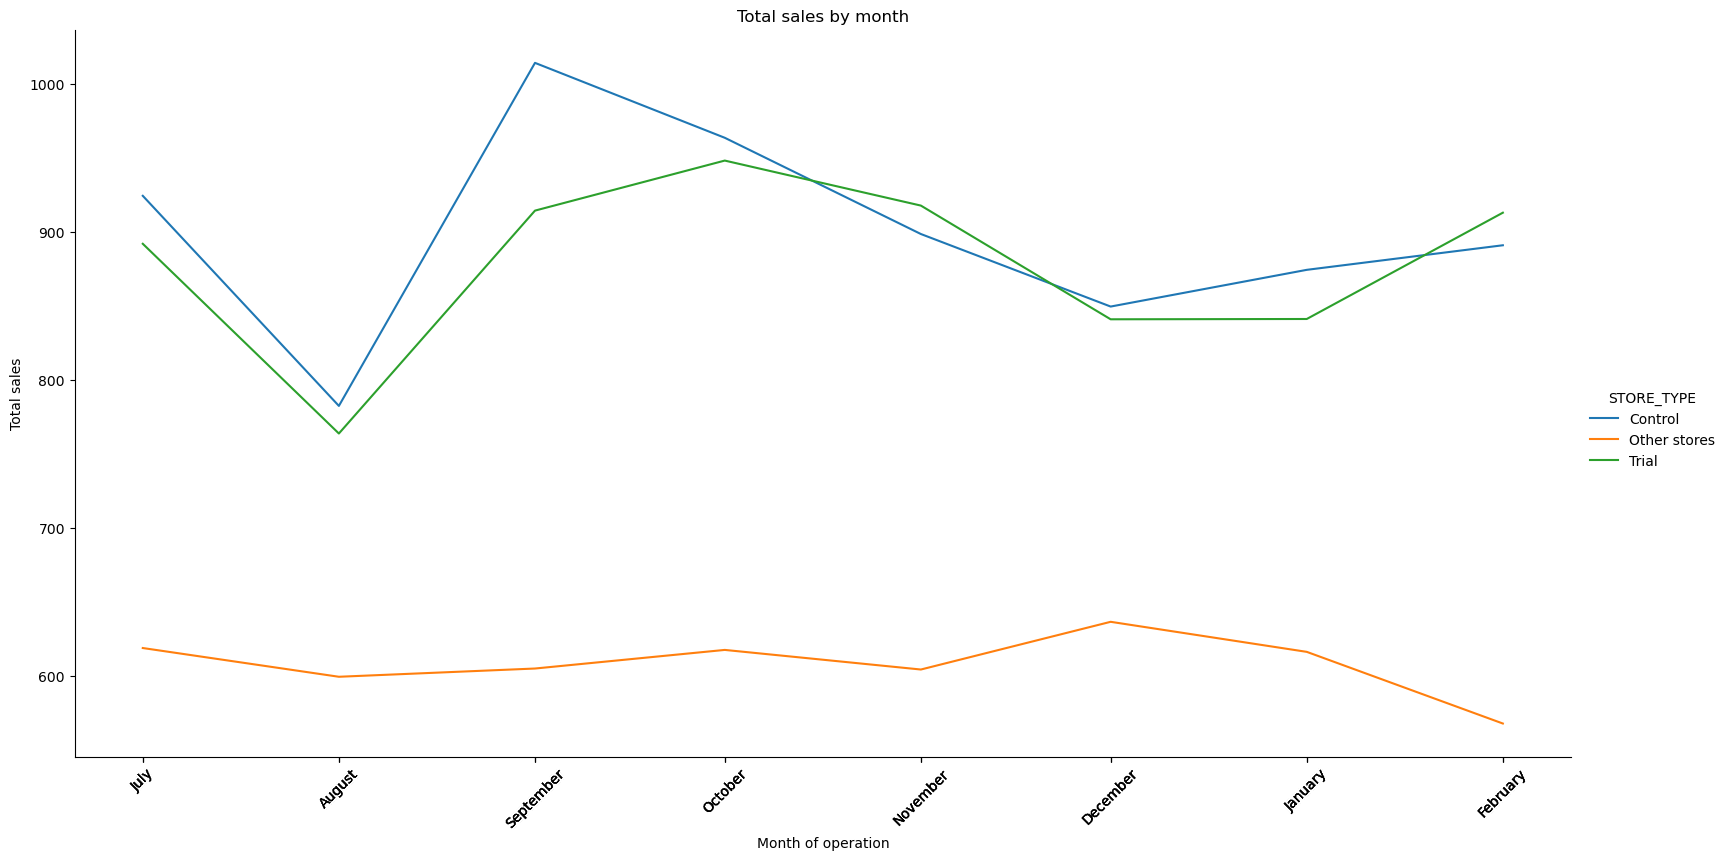

In [72]:
past_sales_86_155 = performance(86, 155, "TOT_SALES")
plot_sales_86_155 = sales_comparison_plots(past_sales_86_155,
                                           'TRANSACTION_MONTH',
                                           'TOT_SALES',
                                           'STORE_TYPE',
                                           'line')

In [73]:
sales_scaling_factor_155 = scaling_factor(pre_trial_measures, 'TOT_SALES', 86, 155)
sales_scaling_factor_155

0.9700651481287743

In [74]:
sales_percentage_difference_86_155 = metric_percentage_difference(86, 155, 'TOT_SALES', sales_scaling_factor_155, 'CONTROL_SALES')

sales_percentage_difference_86_155['PERCENTAGE_DIFF'] = abs(sales_percentage_difference_86_155['CONTROL_SALES']-
                                                           sales_percentage_difference_86_155['TOT_SALES_trial'])/\
                                                            sales_percentage_difference_86_155['CONTROL_SALES']

sales_percentage_difference_86_155['TRANSACTION_MONTH'] = sales_percentage_difference_86_155['MONTH'].astype(str)
sales_percentage_difference_86_155['TRANSACTION_MONTH'] = pd.to_datetime(sales_percentage_difference_86_155['TRANSACTION_MONTH'], format='%Y-%m-%d')

sales_std_dev_86_155 = sales_percentage_difference_86_155[sales_percentage_difference_86_155['MONTH']<'2019-02']['PERCENTAGE_DIFF'].std()
sales_std_dev_86_155

0.025833952854772368

In [75]:
sales_percentage_difference_86_155['t_value'] = (sales_percentage_difference_86_155['PERCENTAGE_DIFF'] - 0) / sales_std_dev_86_155
sales_percentage_difference_86_155.head()

,STORE_NBR,MONTH,TOT_SALES_control,NO_OF_CUSTOMERS,PROD_QTY,AVG_TXN_PER_CUSTOMER,AVG_PRICE_PER_UNIT,CONTROL_SALES,TOT_SALES_trial,PERCENTAGE_DIFF,TRANSACTION_MONTH,t_value
0,155,2018-07,924.6,101,2.000000,1.237624,3.698400,896.922236,892.20,0.005265,2018-07-01,0.203799
1,155,2018-08,782.7,91,1.908333,1.318681,3.417904,759.269991,764.05,0.006296,2018-08-01,0.243692
2,155,2018-09,1014.4,103,2.000000,1.407767,3.497931,984.034086,914.60,0.070561,2018-09-01,2.731315
3,155,2018-10,963.8,108,2.000000,1.259259,3.543382,934.948790,948.40,0.014387,2018-10-01,0.556907
4,155,2018-11,898.8,101,2.000000,1.336634,3.328889,871.894555,918.00,0.052880,2018-11-01,2.046904


In [76]:
trial_period = ['2019-02-01', '2019-03-01', '2019-04-01']
sales_percentage_difference_86_155[sales_percentage_difference_86_155['TRANSACTION_MONTH'].isin(trial_period)][['TRANSACTION_MONTH','t_value']]

,TRANSACTION_MONTH,t_value
7,2019-02-01,2.179542
8,2019-03-01,12.226922
9,2019-04-01,1.364580


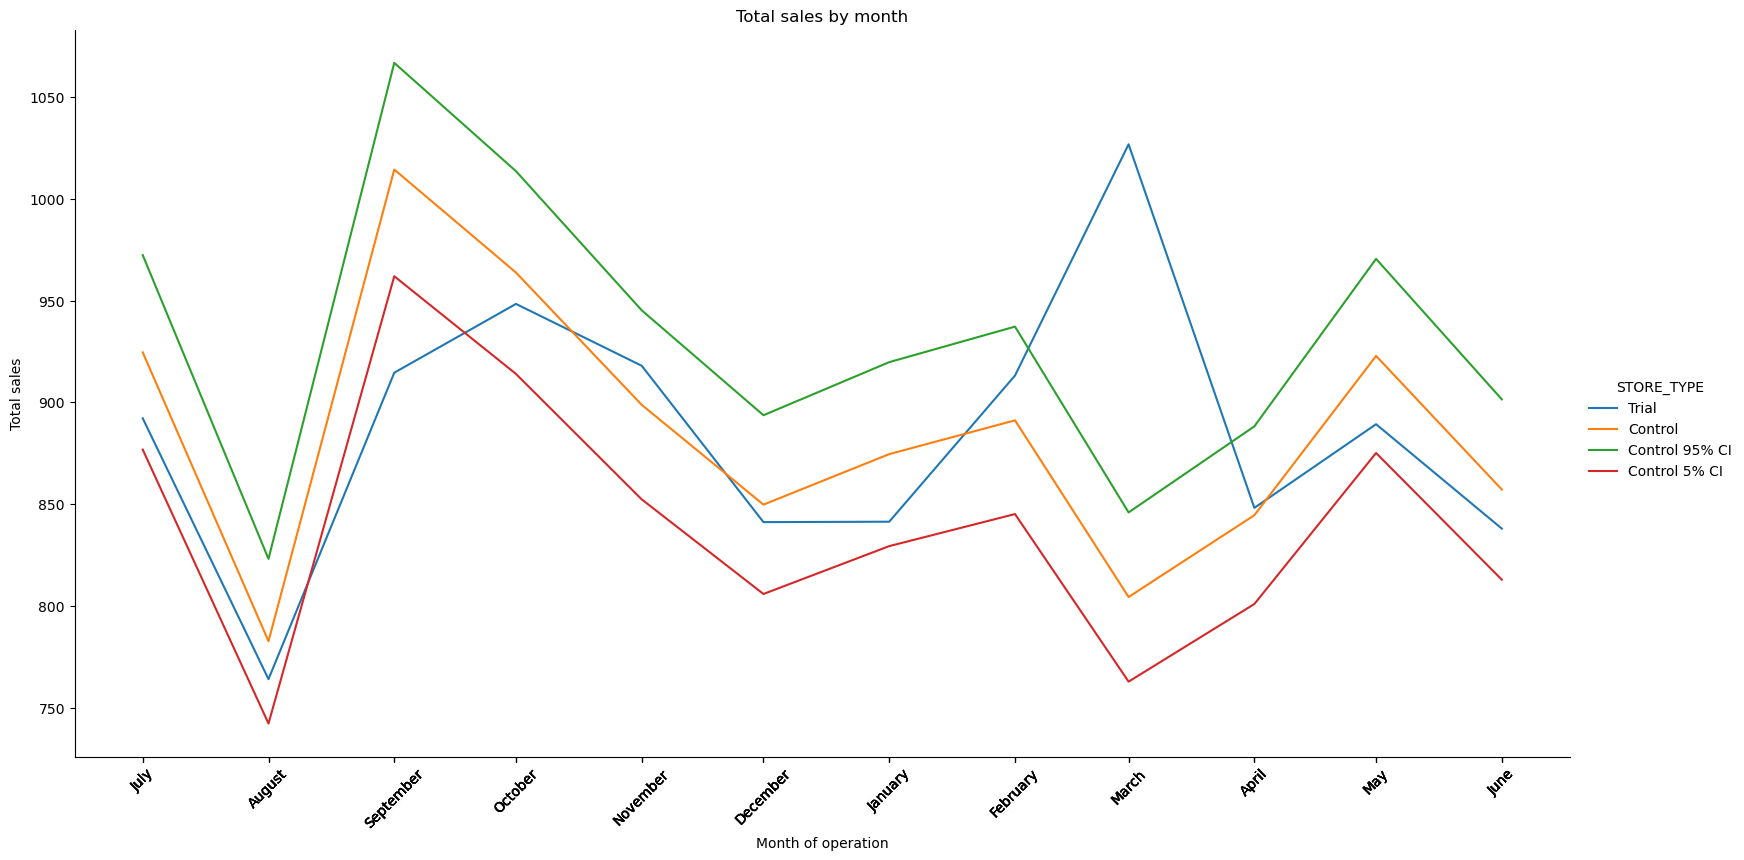

In [77]:
trial_86_control_155_sales_assessment = trial_and_control_assessemnt(86, 155, "TOT_SALES", sales_std_dev_86_155)
sales_comparison_plots(trial_86_control_155_sales_assessment,
                       'TRANSACTION_MONTH',
                       'TOT_SALES', 
                       'STORE_TYPE',
                       'line')

# Customers analysis of trial store 86 and its contol store 155

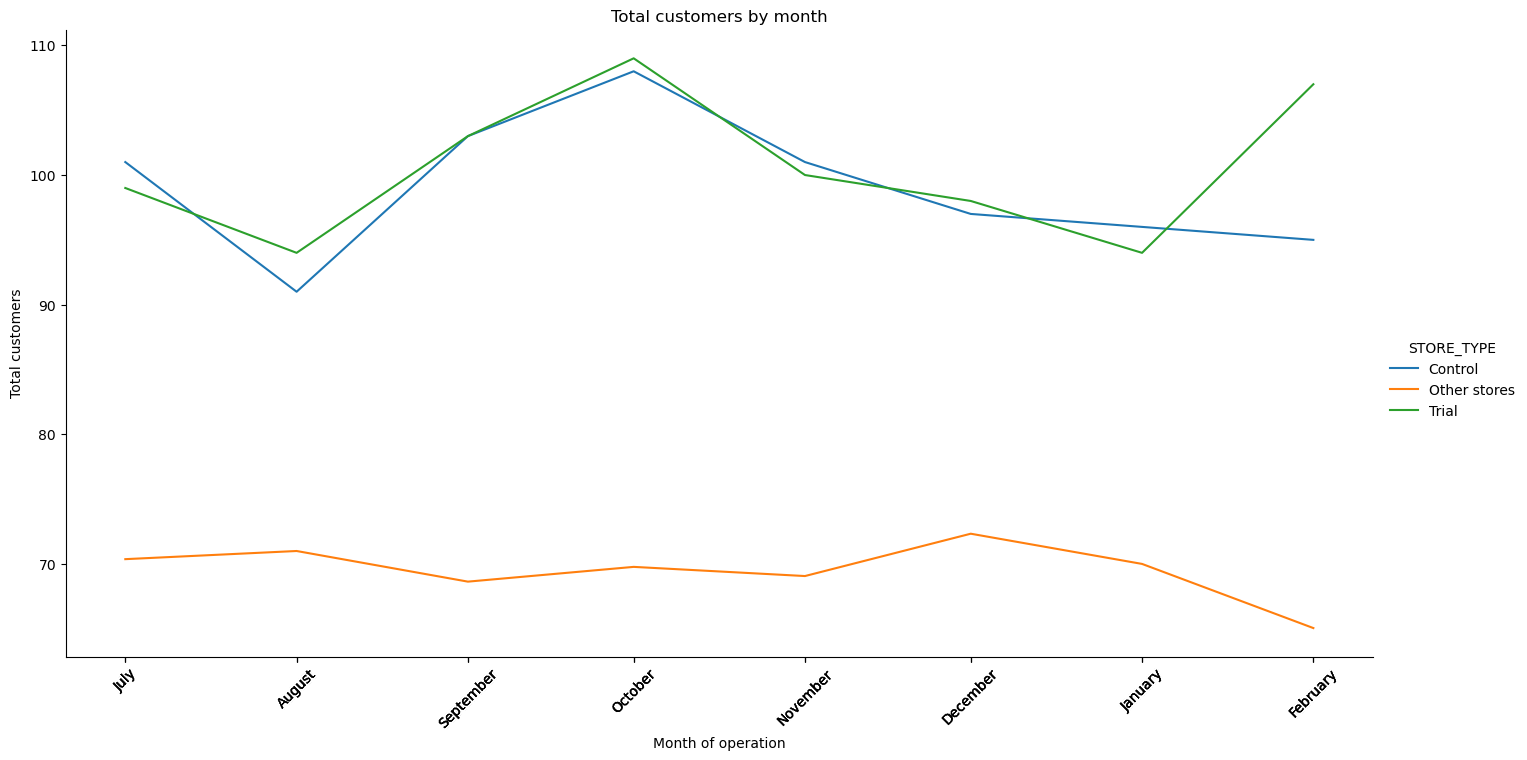

In [78]:
past_customers_86_155 = performance(86, 155, "NO_OF_CUSTOMERS")
past_customers_86_155 = customers_comparison_plots(past_customers_86_155,
                                                   'TRANSACTION_MONTH',
                                                   'NO_OF_CUSTOMERS',
                                                   'STORE_TYPE',
                                                   'line')

In [79]:
customers_scaling_factor_155 = scaling_factor(pre_trial_measures, 'NO_OF_CUSTOMERS', 86, 155)
customers_scaling_factor_155

1.0

In [80]:
customers_percentage_difference_86_155 = metric_percentage_difference(86, 155, 'NO_OF_CUSTOMERS', customers_scaling_factor_155, 'CONTROL_CUSTOMERS')

customers_percentage_difference_86_155['PERCENTAGE_DIFF'] = abs(customers_percentage_difference_86_155['CONTROL_CUSTOMERS']-
                                                           customers_percentage_difference_86_155['NO_OF_CUSTOMERS_trial'])/\
                                                            customers_percentage_difference_86_155['CONTROL_CUSTOMERS']

customers_percentage_difference_86_155['TRANSACTION_MONTH'] = customers_percentage_difference_86_155['MONTH'].astype(str)
customers_percentage_difference_86_155['TRANSACTION_MONTH'] = pd.to_datetime(customers_percentage_difference_86_155['TRANSACTION_MONTH'], format='%Y-%m-%d')

customers_std_dev_86_155 = customers_percentage_difference_86_155[customers_percentage_difference_86_155['MONTH']<'2019-02']['PERCENTAGE_DIFF'].std()
customers_std_dev_86_155

0.010687444701395238

In [81]:
customers_percentage_difference_86_155['t_value'] = (customers_percentage_difference_86_155['PERCENTAGE_DIFF'] - 0) / customers_std_dev_86_155
customers_percentage_difference_86_155.head()

,STORE_NBR,MONTH,TOT_SALES,NO_OF_CUSTOMERS_control,PROD_QTY,AVG_TXN_PER_CUSTOMER,AVG_PRICE_PER_UNIT,CONTROL_CUSTOMERS,NO_OF_CUSTOMERS_trial,PERCENTAGE_DIFF,TRANSACTION_MONTH,t_value
0,155,2018-07,924.6,101,2.000000,1.237624,3.698400,101.0,99,0.019802,2018-07-01,1.852826
1,155,2018-08,782.7,91,1.908333,1.318681,3.417904,91.0,94,0.032967,2018-08-01,3.084651
2,155,2018-09,1014.4,103,2.000000,1.407767,3.497931,103.0,103,0.000000,2018-09-01,0.000000
3,155,2018-10,963.8,108,2.000000,1.259259,3.543382,108.0,109,0.009259,2018-10-01,0.866368
4,155,2018-11,898.8,101,2.000000,1.336634,3.328889,101.0,100,0.009901,2018-11-01,0.926413


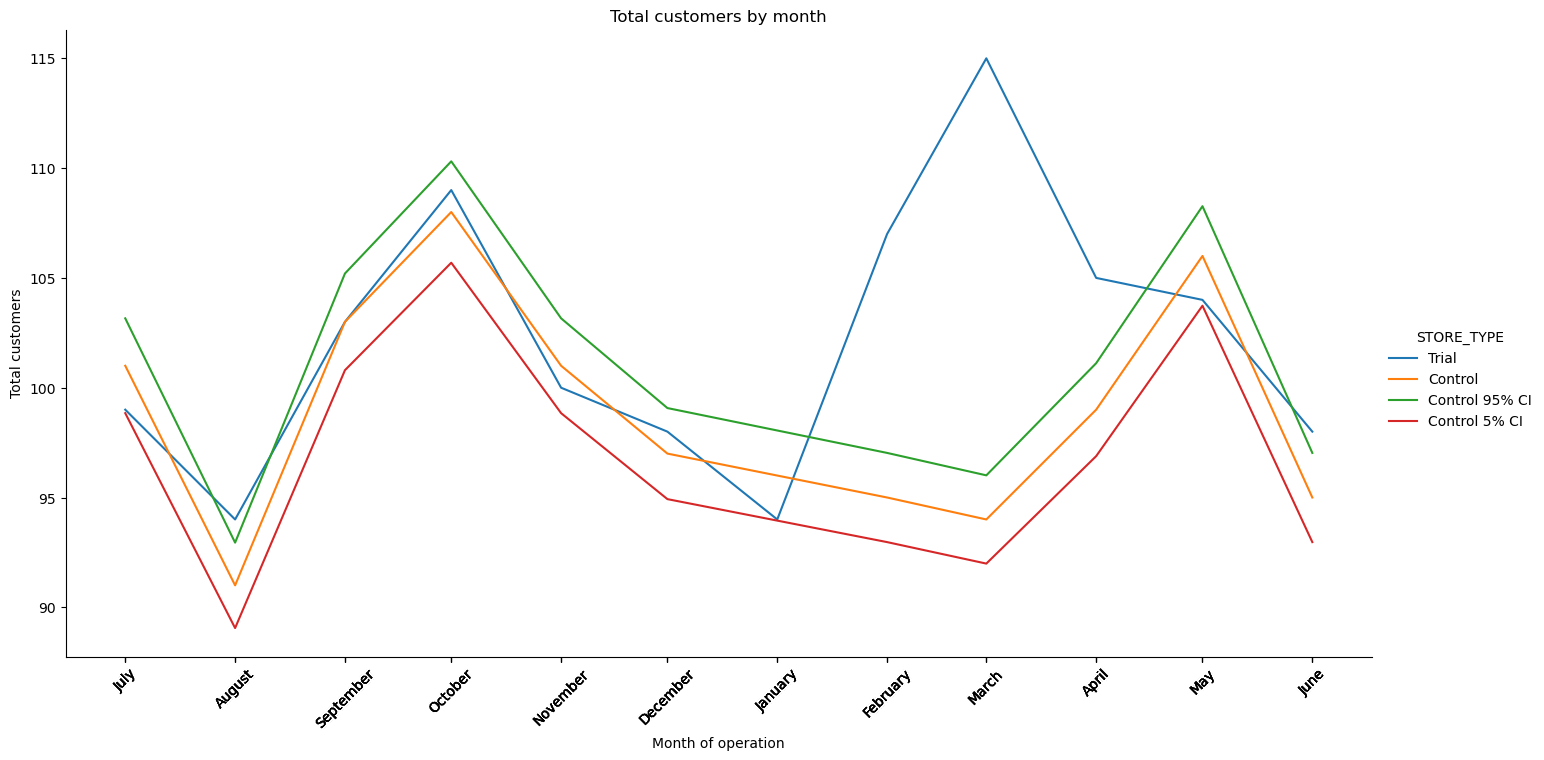

In [82]:
trial_86_control_155_sales_assessment = trial_and_control_assessemnt(86, 155, "NO_OF_CUSTOMERS", customers_std_dev_86_155)
customers_comparison_plots(trial_86_control_155_sales_assessment,
                           'TRANSACTION_MONTH',
                           'NO_OF_CUSTOMERS', 
                           'STORE_TYPE',
                           'line')

# Analysis of trial store 88

In [83]:
store_88_sales_corr = correlation_calculation(pre_trial_measures, 'TOT_SALES', 88)
store_88_customers_corr = correlation_calculation(pre_trial_measures, 'NO_OF_CUSTOMERS', 88)

In [84]:
store_88_sales_magnitude = magnitude_calculation(pre_trial_measures, 'TOT_SALES', 88)
store_88_customers_magnitude = magnitude_calculation(pre_trial_measures, 'NO_OF_CUSTOMERS', 88)

In [85]:
score_control_88 = score_control(store_88_sales_corr,
                                store_88_sales_magnitude,
                                store_88_customers_corr,
                                store_88_customers_magnitude,
                                'control_store')

score_control_88.head()

,trial_store_x_sales,control_store,correlation_sales,magnitude_measure_sales,sales_score,correlation_customers,magnitude_measure_customers,customers_score,final_control_score
0,88,1,0.813636,0.143453,0.478544,0.305334,0.353668,0.329501,0.404023
1,88,2,-0.067927,0.116355,0.024214,-0.452379,0.302289,-0.075045,-0.025415
2,88,3,-0.507847,0.806064,0.149108,0.522884,0.849307,0.686095,0.417602
3,88,4,-0.745566,0.901383,0.077909,-0.361503,0.930930,0.284713,0.181311
4,88,5,0.190330,0.612614,0.401472,-0.025320,0.742127,0.358403,0.379938


In [86]:
control_store_88 = score_control_88[score_control_88['final_control_score']==score_control_88['final_control_score'].max()]['control_store']
control_store_88

224    237
Name: control_store, dtype: object

# The control store for trial store 88 is store 237

# Sales analysis of trial store 88 and control store 237

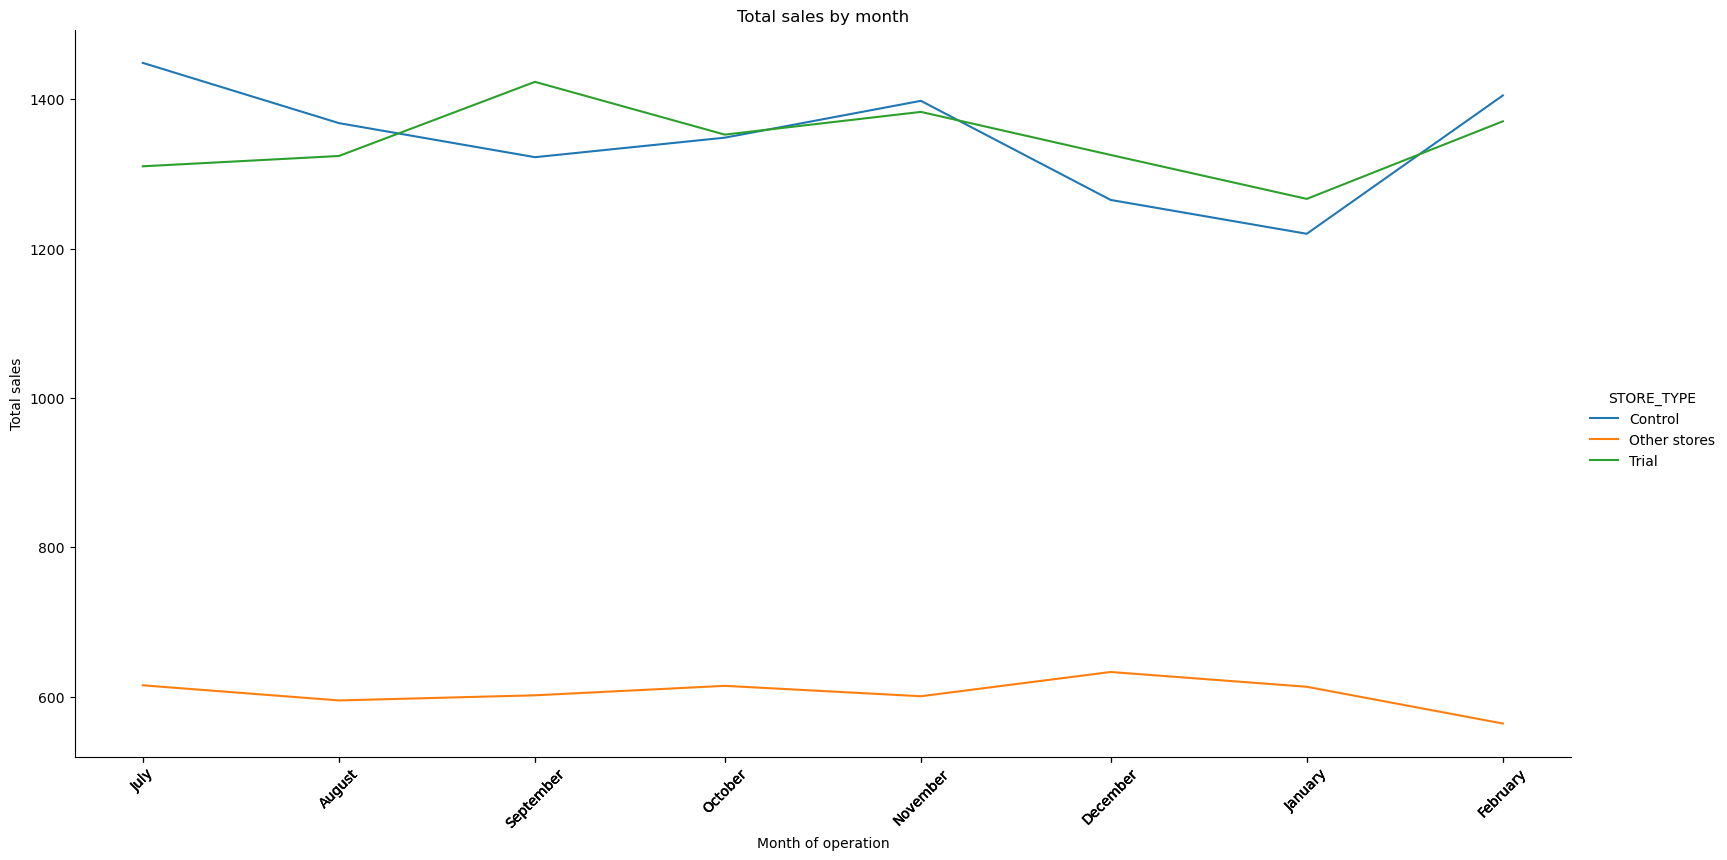

In [87]:
past_sales_88_237 = performance(88, 237, "TOT_SALES")
plot_sales_88_237 = sales_comparison_plots(past_sales_88_237, 
                                           'TRANSACTION_MONTH', 
                                           'TOT_SALES', 
                                           'STORE_TYPE',
                                           'line')

In [88]:
sales_scaling_factor_237 = scaling_factor(pre_trial_measures, 'TOT_SALES', 88, 237)
sales_scaling_factor_237

1.001558330664959

In [89]:
sales_percentage_difference_88_237 = metric_percentage_difference(86, 155, 'TOT_SALES', sales_scaling_factor_155, 'CONTROL_SALES')

sales_percentage_difference_88_237['PERCENTAGE_DIFF'] = abs(sales_percentage_difference_88_237['CONTROL_SALES']-
                                                           sales_percentage_difference_88_237['TOT_SALES_trial'])/\
                                                            sales_percentage_difference_88_237['CONTROL_SALES']

sales_percentage_difference_88_237['TRANSACTION_MONTH'] = sales_percentage_difference_88_237['MONTH'].astype(str)
sales_percentage_difference_88_237['TRANSACTION_MONTH'] = pd.to_datetime(sales_percentage_difference_88_237['TRANSACTION_MONTH'], format='%Y-%m-%d')

sales_std_dev_88_237 = sales_percentage_difference_88_237[sales_percentage_difference_88_237['MONTH']<'2019-02']['PERCENTAGE_DIFF'].std()
sales_std_dev_88_237


0.025833952854772368

In [90]:
sales_percentage_difference_88_237['t_value'] = (sales_percentage_difference_88_237['PERCENTAGE_DIFF'] - 0) / sales_std_dev_88_237
sales_percentage_difference_88_237.head()

,STORE_NBR,MONTH,TOT_SALES_control,NO_OF_CUSTOMERS,PROD_QTY,AVG_TXN_PER_CUSTOMER,AVG_PRICE_PER_UNIT,CONTROL_SALES,TOT_SALES_trial,PERCENTAGE_DIFF,TRANSACTION_MONTH,t_value
0,155,2018-07,924.6,101,2.000000,1.237624,3.698400,896.922236,892.20,0.005265,2018-07-01,0.203799
1,155,2018-08,782.7,91,1.908333,1.318681,3.417904,759.269991,764.05,0.006296,2018-08-01,0.243692
2,155,2018-09,1014.4,103,2.000000,1.407767,3.497931,984.034086,914.60,0.070561,2018-09-01,2.731315
3,155,2018-10,963.8,108,2.000000,1.259259,3.543382,934.948790,948.40,0.014387,2018-10-01,0.556907
4,155,2018-11,898.8,101,2.000000,1.336634,3.328889,871.894555,918.00,0.052880,2018-11-01,2.046904


In [91]:
trial_period = ['2019-02-01', '2019-03-01', '2019-04-01']
sales_percentage_difference_88_237[sales_percentage_difference_88_237['TRANSACTION_MONTH'].isin(trial_period)][['TRANSACTION_MONTH','t_value']]

,TRANSACTION_MONTH,t_value
7,2019-02-01,2.179542
8,2019-03-01,12.226922
9,2019-04-01,1.364580


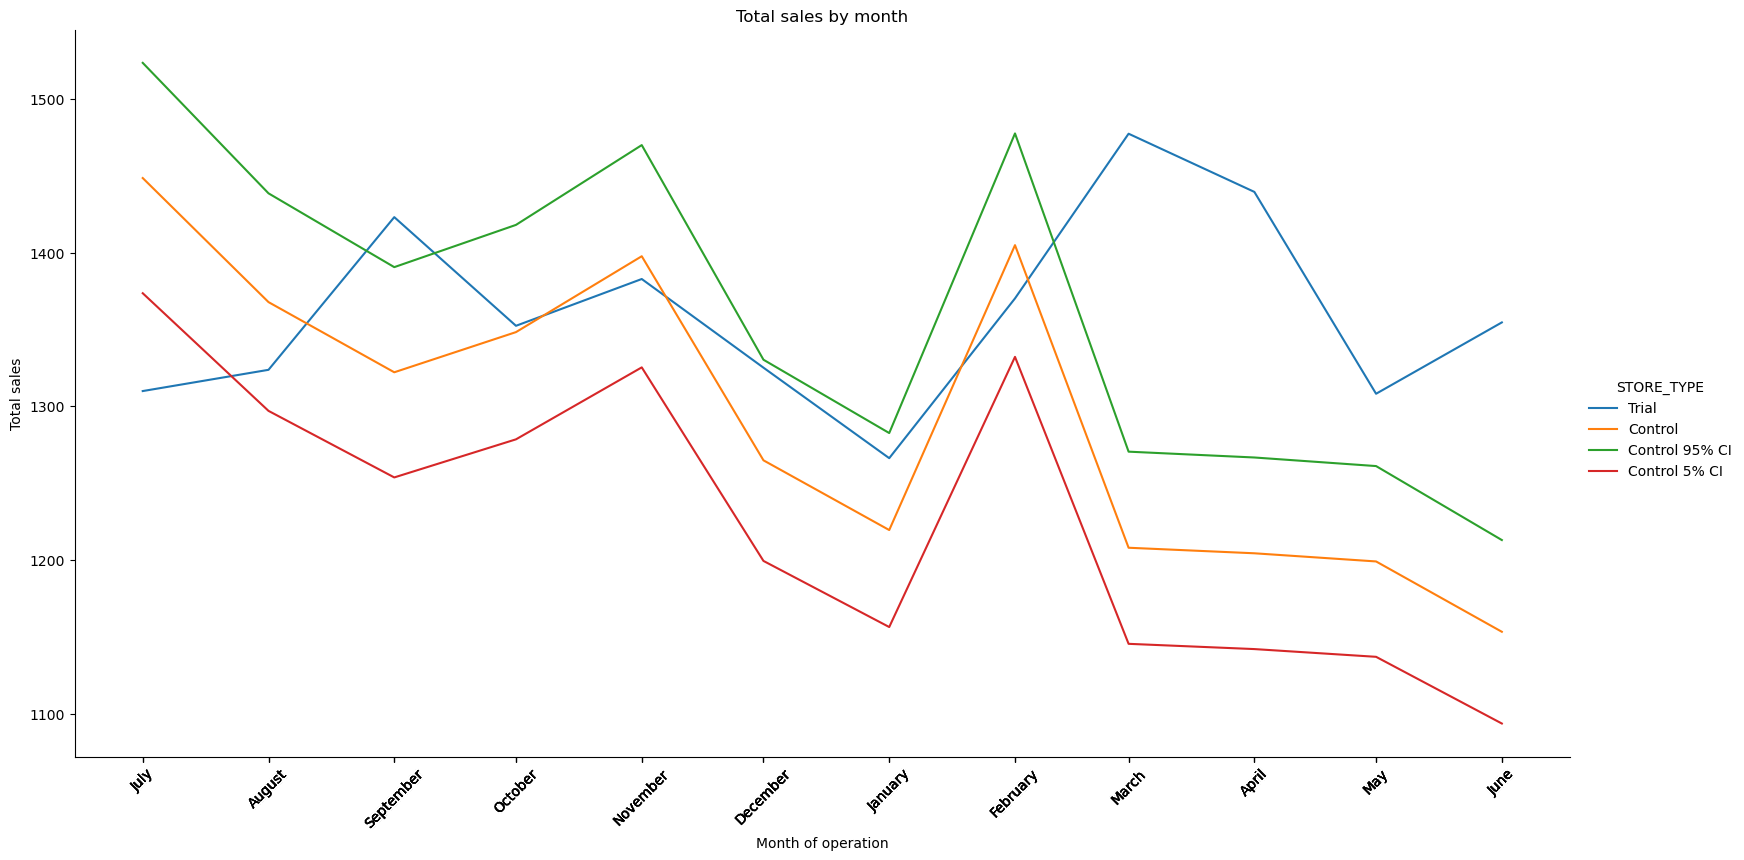

In [92]:
trial_88_control_237_sales_assessment = trial_and_control_assessemnt(88, 237, "TOT_SALES", sales_std_dev_88_237)
sales_comparison_plots(trial_88_control_237_sales_assessment,
                       'TRANSACTION_MONTH',
                       'TOT_SALES', 
                       'STORE_TYPE',
                       'line')

# Customers analysis of trial store 88 and control store 237

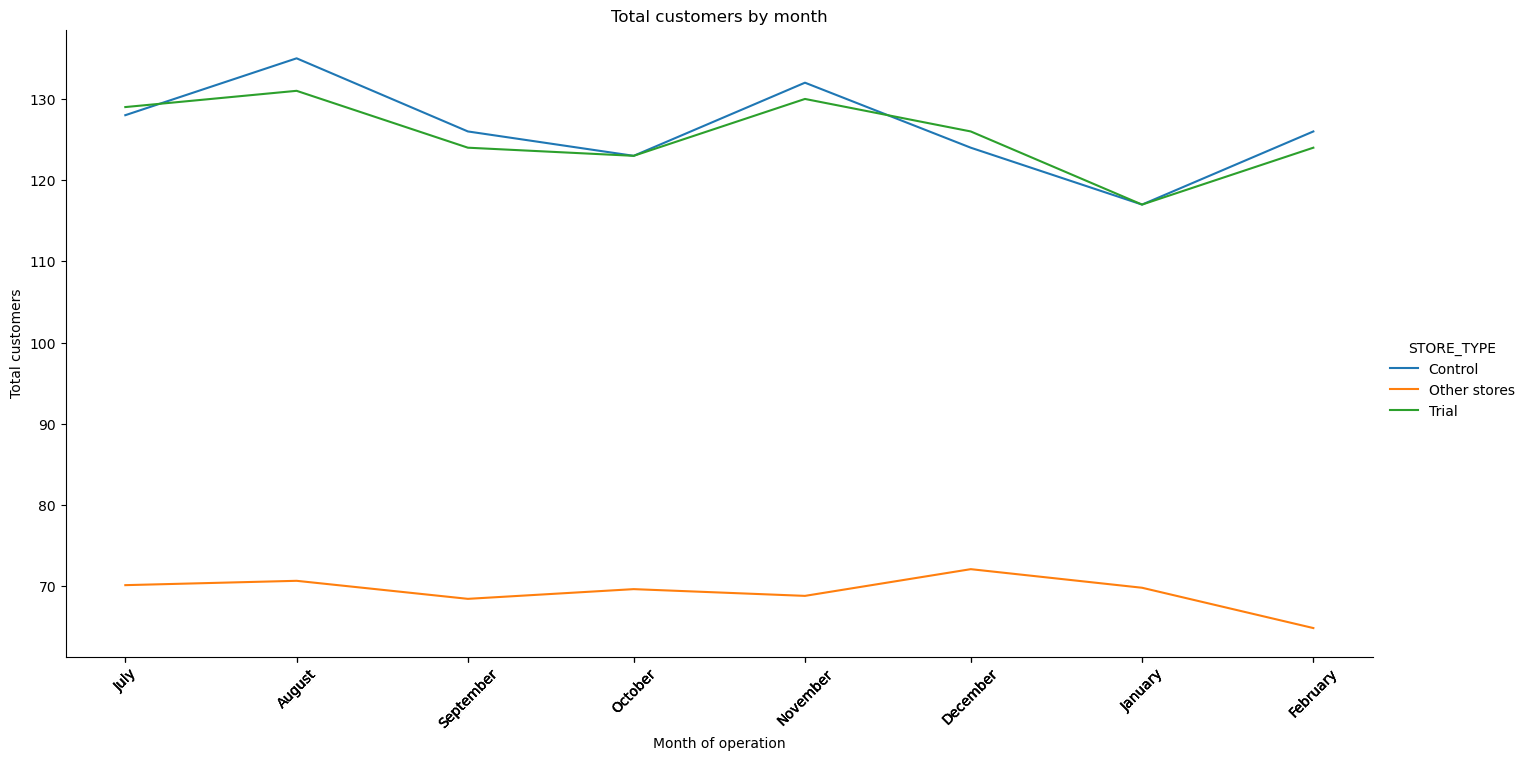

In [93]:
past_customers_88_237 = performance(88, 237, "NO_OF_CUSTOMERS")
plot_customers_88_237 = customers_comparison_plots(past_customers_88_237,
                                                   'TRANSACTION_MONTH',
                                                   'NO_OF_CUSTOMERS',
                                                   'STORE_TYPE',
                                                   'line')

In [94]:
customers_scaling_factor_237 = scaling_factor(pre_trial_measures, 'NO_OF_CUSTOMERS', 88, 237)
customers_scaling_factor_237

0.9943502824858758

In [95]:
customers_percentage_difference_88_237 = metric_percentage_difference(88, 237, 'NO_OF_CUSTOMERS', customers_scaling_factor_237, 'CONTROL_CUSTOMERS')

customers_percentage_difference_88_237['PERCENTAGE_DIFF'] = abs(customers_percentage_difference_88_237['CONTROL_CUSTOMERS']-
                                                           customers_percentage_difference_88_237['NO_OF_CUSTOMERS_trial'])/\
                                                            customers_percentage_difference_88_237['CONTROL_CUSTOMERS']

customers_percentage_difference_88_237['TRANSACTION_MONTH'] = customers_percentage_difference_88_237['MONTH'].astype(str)
customers_percentage_difference_88_237['TRANSACTION_MONTH'] = pd.to_datetime(customers_percentage_difference_88_237['TRANSACTION_MONTH'], format='%Y-%m-%d')

customers_std_dev_88_237 = customers_percentage_difference_86_155[customers_percentage_difference_86_155['MONTH']<'2019-02']['PERCENTAGE_DIFF'].std()
customers_std_dev_88_237

0.010687444701395238

In [96]:
customers_percentage_difference_88_237['t_value'] = (customers_percentage_difference_88_237['PERCENTAGE_DIFF'] - 0) / customers_std_dev_88_237
customers_percentage_difference_88_237.head()

,STORE_NBR,MONTH,TOT_SALES,NO_OF_CUSTOMERS_control,PROD_QTY,AVG_TXN_PER_CUSTOMER,AVG_PRICE_PER_UNIT,CONTROL_CUSTOMERS,NO_OF_CUSTOMERS_trial,PERCENTAGE_DIFF,TRANSACTION_MONTH,t_value
0,237,2018-07,1448.4,128,2.000000,1.265625,4.470370,127.276836,129,0.013539,2018-07-01,1.266786
1,237,2018-08,1367.8,135,1.885542,1.229630,4.369968,134.237288,131,0.024116,2018-08-01,2.256495
2,237,2018-09,1322.2,126,1.993333,1.190476,4.422074,125.288136,124,0.010281,2018-09-01,0.962006
3,237,2018-10,1348.3,123,1.993333,1.219512,4.509365,122.305085,123,0.005682,2018-10-01,0.531635
4,237,2018-11,1397.6,132,1.987578,1.219697,4.367500,131.254237,130,0.009556,2018-11-01,0.894113


In [97]:
trial_period = ['2019-02-01', '2019-03-01', '2019-04-01']
customers_percentage_difference_88_237[customers_percentage_difference_88_237['TRANSACTION_MONTH'].isin(trial_period)][['TRANSACTION_MONTH','t_value']]

,TRANSACTION_MONTH,t_value
7,2019-02-01,0.962006
8,2019-03-01,12.392900
9,2019-04-01,6.804926


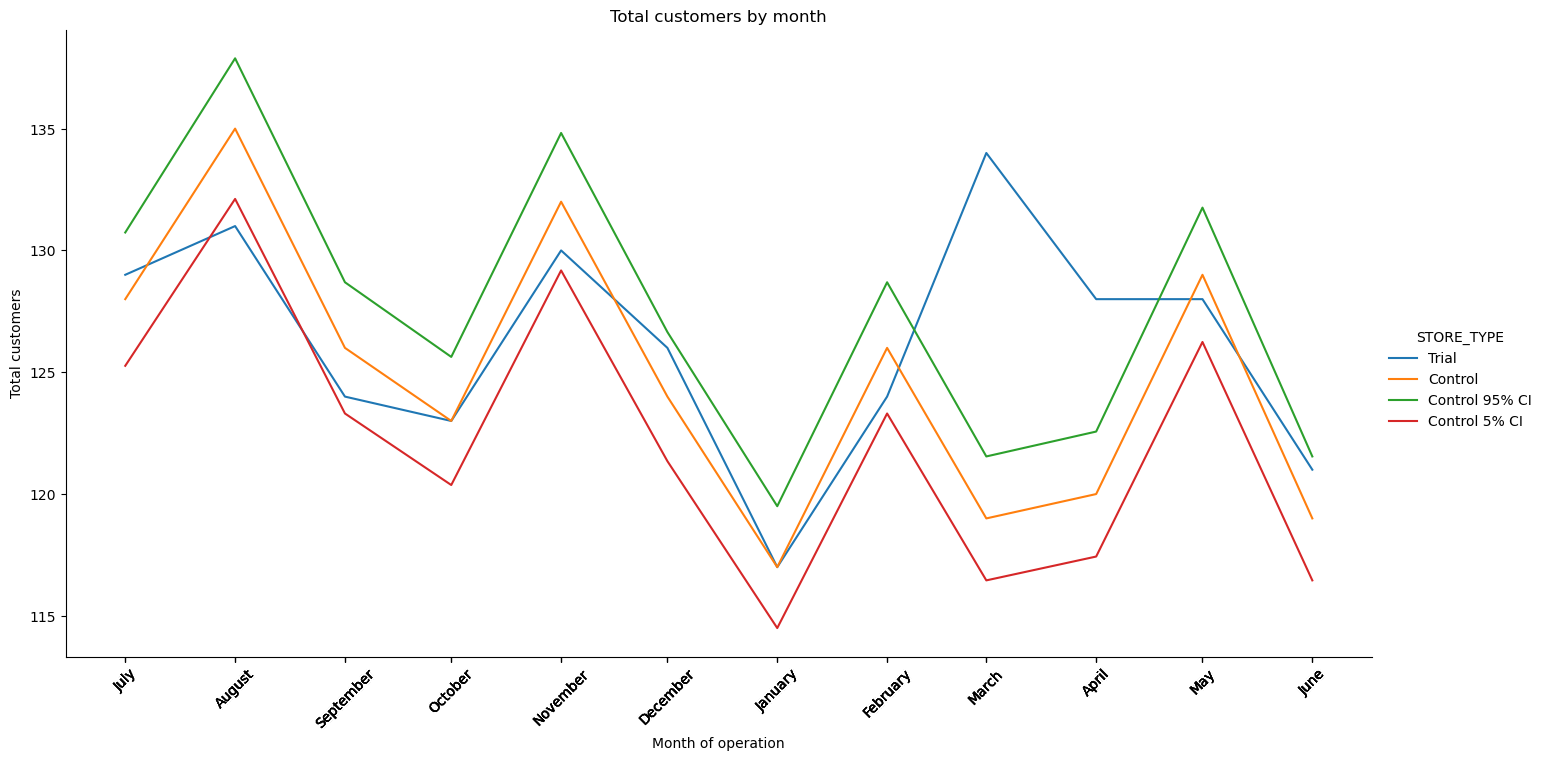

In [98]:
trial_88_control_237_customers_assessment = trial_and_control_assessemnt(88, 237, "NO_OF_CUSTOMERS", customers_std_dev_88_237)
customers_comparison_plots(trial_88_control_237_customers_assessment,
                           'TRANSACTION_MONTH',
                           'NO_OF_CUSTOMERS',
                           'STORE_TYPE',
                           'line')